### Import modules

In [1]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

# NYCOD

## Import

In [3]:
import pandas as pd
import numpy as np

#read in sales data, already subsetted to include Manhattan only
sales17 = pd.read_csv("INPUT_nycod/2017_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales18 = pd.read_csv("INPUT_nycod/2018_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales19 = pd.read_csv("INPUT_nycod/2019_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales20 = pd.read_csv("INPUT_nycod/2020_manhattan.csv", skiprows=7, header=None).dropna(how='all')
sales21 = pd.read_csv("INPUT_nycod/2021_manhattan.csv", skiprows=7, header=None).dropna(how='all')
sales22 = pd.read_csv("INPUT_nycod/rollingsales_manhattan.csv", skiprows=1, header=None).dropna(how='all')

#concatenate all dfs, check shape
allsales = pd.concat((sales17, sales18, sales19, sales20, sales21, sales22), axis=0)
allsales = allsales.iloc[:,0:21]
print(allsales.shape)

#add labels
labels = pd.DataFrame(pd.read_csv("INPUT_nycod/2021_manhattan.csv", header=6).columns).T
allsales = pd.concat((labels, allsales), axis=0)
allsales.columns = allsales.iloc[0] 
allsales = allsales[1:]

(110226, 21)


## Clean

### Dtype handling

In [4]:
#convert objects to numeric where possible
allsales['BOROUGH'] = allsales['BOROUGH'].astype(np.int64)
allsales['BLOCK'] = allsales['BLOCK'].astype(np.int64)
allsales['LOT'] = allsales['LOT'].astype(np.int64)
allsales['RESIDENTIAL\nUNITS'] = pd.to_numeric(allsales['RESIDENTIAL\nUNITS'].str.replace(',',''), errors='coerce')
allsales['TOTAL \nUNITS'] = pd.to_numeric(allsales['TOTAL \nUNITS'].str.replace(',',''), errors='coerce')
allsales['LAND \nSQUARE FEET'] = pd.to_numeric(allsales['LAND \nSQUARE FEET'].str.replace(',',''), errors='coerce')
allsales['GROSS \nSQUARE FEET'] = pd.to_numeric(allsales['GROSS \nSQUARE FEET'].str.replace(',',''), errors='coerce')
allsales['COMMERCIAL\nUNITS'] = pd.to_numeric(allsales['COMMERCIAL\nUNITS'], errors='coerce')
allsales['YEAR BUILT'] = pd.to_numeric(allsales['YEAR BUILT'], errors='coerce')

#clean sale price
prices = []
for i in allsales['SALE PRICE']:
    prices.append(float(i.replace(",", "").replace("'", "").replace("$", "")))
allsales['saleprice'] = prices
allsales = allsales.drop(columns=['SALE PRICE'])

#clean sale date, create 'years old at time of sale' variable
import datetime
dates = []
for i in allsales['SALE DATE']:
    dates.append(datetime.datetime.strptime(i, "%m/%d/%Y"))
allsales['saledate'] = dates
                 
years = []
for i in allsales['SALE DATE']:
    years.append(int(i[-4:]))
allsales['year_clean'] = years
allsales['bldg_age_at_sale_calc'] = allsales.year_clean - allsales['YEAR BUILT']
allsales = allsales.drop(columns=['YEAR BUILT'])
allsales = allsales.drop(columns=['SALE DATE'])
allsales = allsales.drop(columns=['year_clean'])

### Drop bad columns

In [5]:
#drop irrelevant and duplicate columns
allsales = allsales.drop(columns=['NEIGHBORHOOD',
                                  'BOROUGH', 
                                  'BUILDING CLASS CATEGORY', 
                                  'TAX CLASS AT PRESENT', 
                                  'BUILDING CLASS AT PRESENT',
                                  'TAX CLASS AT TIME OF SALE',
                                  'BUILDING CLASS\nAT TIME OF SALE',
                                  'EASE-MENT'])

#rename columns for interpretability
col_mapper = {'RESIDENTIAL\nUNITS':'units_residential',
             'COMMERCIAL\nUNITS':'units_commercial',
             'TOTAL \nUNITS':'units_total',
             'LAND \nSQUARE FEET': 'area_land',
             'GROSS \nSQUARE FEET': 'area_gross'}

allsales = allsales.rename(mapper=col_mapper, axis=1)

In [6]:
#lowercase and rename
allsales.columns = map(str.lower, allsales.columns)
allsales.columns = [i.replace('\n', " ").replace("  ", " ").replace(" ","") for i in allsales.columns]

allsales = allsales.drop(columns=['area_gross',
                     'area_land',
                     'units_total',
                     'apartmentnumber'])

### Visualize rows to be dropped - sale price == 0, residential units == NaN

total observations: 110226
non-sale transfers (sale price 0): 21787
sales (sale price > 0): 88439


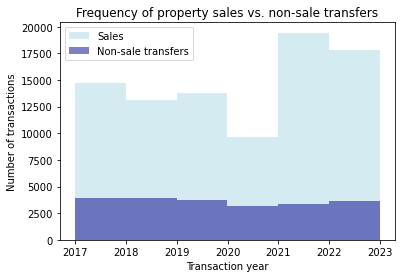

In [8]:
#FOR VIZ ONLY
#missing sale price
print("total observations: {}".format(len(allsales)))
print("non-sale transfers (sale price 0): {}".format(len(allsales[allsales['saleprice'] == 0])))
print("sales (sale price > 0): {}".format(len(allsales[allsales['saleprice'] > 0])))

import matplotlib.pyplot as plt
plt.hist(allsales[allsales.saleprice > 0].saledate, alpha=0.5, color='lightblue', label='Sales', bins=6)
plt.hist(allsales[allsales.saleprice == 0].saledate, alpha=0.5, color='darkblue', label='Non-sale transfers', bins=6)
plt.legend()
plt.title('Frequency of property sales vs. non-sale transfers')
plt.xlabel('Transaction year')
plt.ylabel('Number of transactions')
plt.savefig('OUTPUT_visualizations/1.Sales vs. non-sale transfers.png')
plt.show()

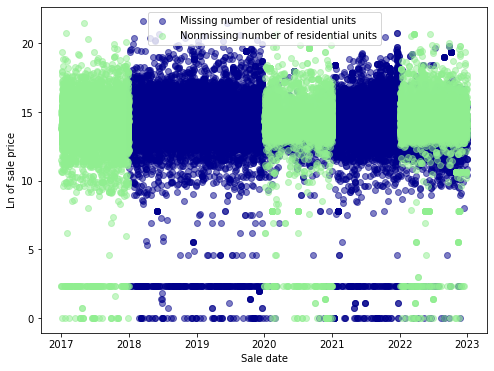

In [9]:
#dates of missing and nonmissing residential units

a = allsales[allsales['units_residential']>=-1]
b = allsales[allsales['units_residential'].isna() == True]

plt.figure(figsize=(8,6))
plt.scatter(b.saledate, np.log(b.saleprice), label='Missing number of residential units', color='darkblue', alpha=0.5)
plt.scatter(a.saledate, np.log(a.saleprice), label='Nonmissing number of residential units', color='lightgreen', alpha=0.5)
plt.xlabel('Sale date')
plt.ylabel('Ln of sale price')
plt.legend()
plt.savefig('OUTPUT_visualizations/resunitsmissing.png')
plt.show()

### Drop bad rows (sale price == 0)

In [10]:
#SUBSET DATA
allsales_use = allsales[allsales['saleprice'] > 0]

#after removing zeros
allsales_use['log_saleprice'] = np.log(allsales_use.saleprice)
allsales_use = allsales_use.drop(columns=['saleprice'])

# PLUTO

## Import

In [11]:
pluto = pd.read_csv("INPUT_pluto/pluto_22v3_1.csv", low_memory=False)
pluto = pluto.dropna(how='all')

#subset to include Manhattan only
man = pluto[pluto['borough']=='MN']
print(man.shape)

(42695, 92)


## Clean

### Dtype handling

In [12]:
#make list of PLUTO categorical columns
cate_cols = pd.DataFrame(man.dtypes)[pd.DataFrame(man.dtypes)[0] == 'object']

#create binary variables: ltdheight, splitzone, histdist, landmark
man['bin_ltdheight'] = abs(1-(man.ltdheight.isna()))
man['bin_splitzone'] = abs(1-(man.splitzone.isna()))
man['bin_histdist'] = abs(1-(man.histdist.isna()))
man['bin_landmark'] = abs(1-(man.landmark.isna()))

#drop all categoricals (including the ones we just recoded) but leave address to use for later recodes
cate_cols = cate_cols.drop('address')
man = man.drop(columns=cate_cols.index) 

print(man.shape)

(42695, 69)


### Add columns

In [13]:
#create FAR variable
man['far_calc'] = man['bldgarea'] / man['lotarea']
man = man.drop(columns=['bldgarea', 'lotarea'])

### Drop bad columns

In [ ]:
#lowercase and rename
man.columns = map(str.lower, man.columns)
man.columns = [i.replace('\n', " ").replace("  ", " ").replace(" ","") for i in man.columns]

man = man.drop(columns=['xcoord',
                     'ycoord',
                     'borocode',
                     'plutomapid',
                     'sanitboro',
                     'unitsres',
                     'zipcode',
                     'areasource',
                     'bbl',
                     'builtfar',
                     'commfar',
                      'cd',
                     'facilfar',
                     'proxcode',
                     'residfar',
                     'taxmap',
                     'unitstotal',
                     'spdist3',
                     'landuse',
                     'easements',
                     'bsmtcode',
                     'assessland',
                     'assesstot',
                     'exempttot',
                     'condono',
                     'lottype',
                     'lotfront',
                     'lotdepth',
                     'bldgfront',
                     'bldgdepth',
                     'appbbl',
                     'tract2010',
                       'bsmtcode',
                       'proxcode',
                       'lottype',
                       'tract2010'])

In [19]:
man.columns

Index(['block', 'lot', 'cd', 'bct2020', 'schooldist', 'council', 'zipcode',
       'policeprct', 'healthcenterdistrict', 'healtharea', 'sanitboro',
       'sanitdistrict', 'address', 'spdist3', 'landuse', 'easements',
       'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
       'strgearea', 'factryarea', 'otherarea', 'areasource', 'numbldgs',
       'numfloors', 'unitsres', 'unitstotal', 'lotfront', 'lotdepth',
       'bldgfront', 'bldgdepth', 'proxcode', 'lottype', 'bsmtcode',
       'assessland', 'assesstot', 'exempttot', 'yearbuilt', 'yearalter1',
       'yearalter2', 'builtfar', 'residfar', 'commfar', 'facilfar', 'borocode',
       'bbl', 'condono', 'tract2010', 'xcoord', 'ycoord', 'taxmap', 'appbbl',
       'plutomapid', 'latitude', 'longitude', 'bin_ltdheight', 'bin_splitzone',
       'bin_histdist', 'bin_landmark', 'far_calc'],
      dtype='object')

In [17]:
binary_cols = ['policeprct','schooldist','healthcenterdistrict', 'sanitdistrict', 'council']
for i in binary_cols:
    man[i] = man[i].astype(object)
    
man.dtypes

block              int64
lot                int64
cd               float64
bct2020          float64
schooldist        object
                  ...   
bin_ltdheight      int32
bin_splitzone      int32
bin_histdist       int32
bin_landmark       int32
far_calc         float64
Length: 62, dtype: object

In [18]:
man = man[man.block < man.block.max()]
print(man.shape)

(42694, 62)


# Merge NYCOD and PLUTO

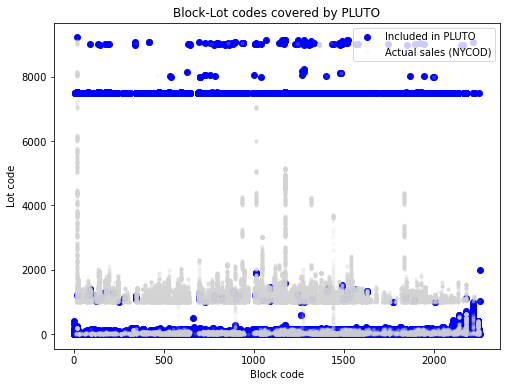

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(man.block, man.lot, label='Included in PLUTO', color='blue', marker='o')
plt.scatter(allsales_use.block, allsales_use.lot, label='Actual sales (NYCOD)', color='lightgray', alpha=0.1, marker='.')
plt.xlabel('Block code')
plt.ylabel('Lot code')
plt.title('Block-Lot codes covered by PLUTO')
plt.legend()
plt.savefig('OUTPUT_visualizations/3.Borough-Lot coverage.png')
plt.show()

In [21]:
for i in allsales_use.columns:
    if i in man.columns:
        print(i)
        
man = man.rename(mapper={'block':'block_pluto',
                        'lot':'lot_pluto',
                        'address':'address_pluto'}, axis=1)

block
lot
address
zipcode


In [22]:
#join based on BBL

df_1 = allsales_use.merge(man, how='left', left_on=['block', 'lot'], right_on=['block_pluto', 'lot_pluto'])
print('Total transactions (from NYCOD): {}'.format(len(df_1)))
print("Successfully mapped to PLUTO via BBL: {:.3f}%".format(100*(len(df_1) - len(df_1[df_1.latitude.isna() == True]))/(len(df_1))))

Total transactions (from NYCOD): 88439
Successfully mapped to PLUTO via BBL: 49.474%


In [23]:
#join based on address

#isolate transactions that were not matched before
missed = df_1[df_1['latitude'].isna() == True].iloc[:,:10]

#clean address text
addresses = []
for i in missed.address:
    addresses.append(i.split(',')[0])
missed['address_clean'] = addresses

#merge on address
df_2 = missed.merge(man, how='left', left_on=['address_clean'], right_on=['address_pluto'])

print('Unmapped transactions (from NYCOD): {}'.format(len(df_2)))
print("Successfully mapped to PLUTO via address: {:.3f}%".format(100*(len(df_2) - len(df_2[df_2.latitude.isna() == True]))/(len(df_2))))

Unmapped transactions (from NYCOD): 49458
Successfully mapped to PLUTO via address: 37.420%


In [24]:
len_all = len(allsales_use)
len_bbl = len(df_1)
len_add = len(df_2)

df_1 = df_1[df_1.latitude.isna() == False].drop(columns=['address'])
df_2 = df_2[df_2.latitude.isna() == False].drop(columns=['address_clean', 'address_pluto'])

print('{} total sales'.format(len_all))
print('{} matched on BBL'.format(len_bbl))
print('{} matched on address'.format(len_add))
print('{} unmatched ({:.3f}% of total)'.format((len_all - len_bbl - len_add), (100*(len_all - len_bbl - len_add)/len_all)))

df = pd.concat((df_1, df_2), axis=0)
#drop unnecessary columns
df = df.drop(columns=['address', 'block_pluto_x', 'block_pluto_y', 'block_pluto', 'lot_pluto',
                     'block', 'lot', 'schooldist', 'council', 'policeprct', 'healthcenterdistrict', 'sanitdistrict'])
df.columns.sort_values()
df.head()
#drop empty
df = df.dropna(how='all', axis=1)
df = df.dropna(how='all', axis=0)
#final df
print('\n')
print('shape of final df: {}'.format(df.shape))

df.to_csv('OUTPUT_cleandata/df_clean.csv')

88439 total sales
88439 matched on BBL
49458 matched on address
-49458 unmatched (-55.923% of total)


shape of final df: (62261, 61)


# Merge in distance datasets

In [25]:
import pandas as pd

hospital = pd.read_csv('INPUT_distances/hospital.csv')
park = pd.read_csv('INPUT_distances/park.csv')
school = pd.read_csv('INPUT_distances/public_school.csv')
subway = pd.read_csv('INPUT_distances/subway.csv')
housing = pd.read_csv('INPUT_distances/affordable_housing.csv')
college = pd.read_csv('INPUT_distances/college_university.csv')
museum = pd.read_csv('INPUT_distances/museum.csv')

In [26]:
dfs = [hospital, park, school, subway, housing, college, museum, df]

for i in dfs:
    print(i.shape)

(83107, 57)
(62261, 76)
(62345, 59)
(62261, 47)
(63820, 83)
(64032, 50)
(62261, 49)
(62261, 61)


In [27]:
df['dist_park'] = park.iloc[:,-1:]
df['dist_subway'] = subway.iloc[:,-1:]
df['dist_hospital'] = hospital.iloc[:len(df), -1:]
df['dist_school'] = school.iloc[:len(df), -1:]
df['dist_housingdev'] = housing.iloc[:len(df), -1:]
df['dist_college'] = college.iloc[:len(df), -1:]
df['dist_museum'] = museum.iloc[:len(df), -1:]

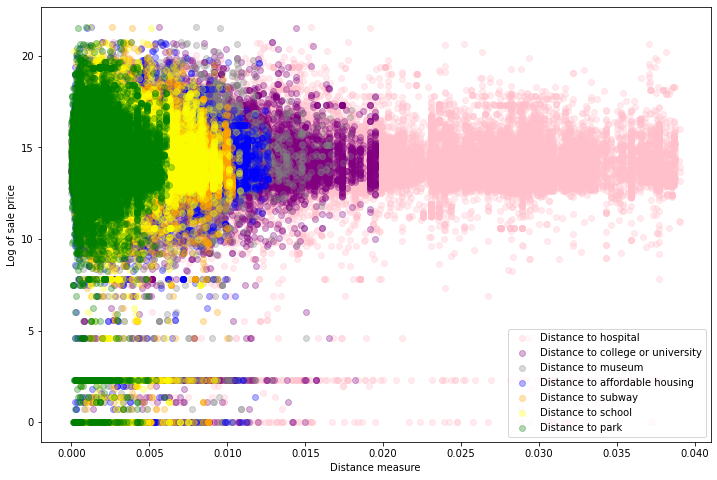

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(df.dist_hospital, df.log_saleprice, color='pink', alpha=0.3, label='Distance to hospital')
plt.scatter(df.dist_college, df.log_saleprice, color='purple', alpha=0.3, label='Distance to college or university')
plt.scatter(df.dist_museum, df.log_saleprice, color='gray', alpha=0.3, label='Distance to museum')
plt.scatter(df.dist_housingdev, df.log_saleprice, color='blue', alpha=0.3, label='Distance to affordable housing')
plt.scatter(df.dist_subway, df.log_saleprice, color='orange', alpha=0.3, label='Distance to subway')
plt.scatter(df.dist_school, df.log_saleprice, color='yellow', alpha=0.3, label='Distance to school')
plt.scatter(df.dist_park, df.log_saleprice, color='green', alpha=0.3, label='Distance to park')
plt.xlabel('Distance measure')
plt.ylabel('Log of sale price')
plt.legend()
plt.savefig('OUTPUT_visualizations/distances.png')
plt.show()

# Full dataset desc. statistics

In [ ]:
#drop empty rows and columns

In [29]:
#drop cols with more than 90% missing data
cols = pd.DataFrame(df.columns).rename(columns={0:'column_name'})
missing = []
for i in cols['column_name']:
    missing.append(100*df[i].isnull().sum()/len(df[i]))
cols['pct_missing'] = missing
to_drop = []
for i in cols.index:
    if cols['pct_missing'][i] > 90:
        to_drop.append(cols['column_name'][i])
df = df.drop(columns=to_drop)

print('Features with > 90% missing data: {} \n'.format(to_drop))
print('Features with any missing data:')
display(cols[cols['pct_missing']>0].sort_values('pct_missing', ascending=False))

Features with > 90% missing data: [] 

Features with any missing data:


,column_name,pct_missing
51,appbbl,78.280143
46,condono,73.919468
60,zipcode,70.275132
1,units_residential,68.607957
2,units_commercial,58.171247
11,address_pluto,29.726474
8,zipcode_y,29.724868
66,dist_college,21.315109
65,dist_housingdev,21.315109
64,dist_school,21.315109


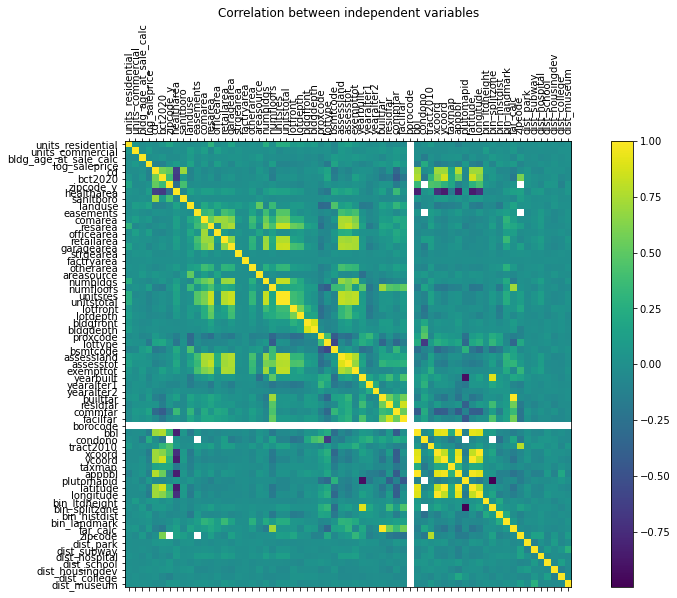

In [30]:
# plot corr matrix of all vars

f = plt.figure(figsize=(14, 8))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation between independent variables')
plt.savefig('OUTPUT_visualizations/4.Corr matrix for all vars.png')
plt.show()

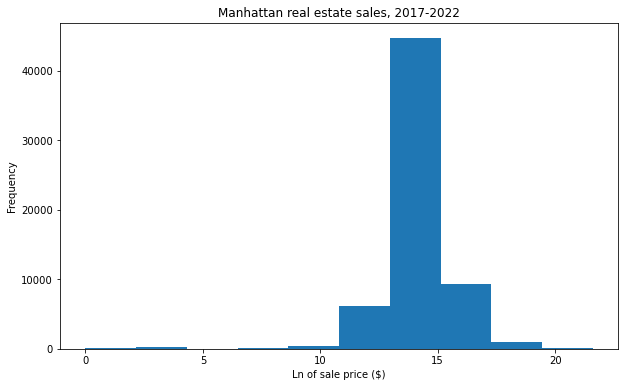

In [31]:
#plot hist of sale prices

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['log_saleprice'])
plt.xlabel('Ln of sale price ($)')
plt.ylabel('Frequency')
plt.title('Manhattan real estate sales, 2017-2022')
plt.savefig('OUTPUT_visualizations/5.Histogram of ln sale price.png')
plt.show()

In [32]:
df.describe()

,units_residential,units_commercial,bldg_age_at_sale_calc,log_saleprice,cd,bct2020,zipcode_y,healtharea,sanitboro,landuse,...,bin_landmark,far_calc,zipcode,dist_park,dist_subway,dist_hospital,dist_school,dist_housingdev,dist_college,dist_museum
count,19545.000000,26043.000000,59799.000000,62261.000000,62261.000000,6.220900e+04,43754.000000,62261.000000,62261.000000,62038.000000,...,62261.000000,60022.000000,18507.000000,48990.000000,48990.000000,48990.000000,48990.000000,48990.000000,48990.000000,48990.000000
mean,4.601279,0.780709,98.586314,14.010797,106.035672,1.012183e+06,10030.796224,4710.509275,1.000739,3.194526,...,0.028862,8.843213,10029.451073,0.001543,0.003311,0.014357,0.002946,0.003044,0.006270,0.004947
std,69.361673,8.890122,235.484370,1.612630,3.968179,6.808326e+03,33.863994,1897.958279,0.027172,0.891456,...,0.167421,5.142790,50.144648,0.001117,0.001961,0.008534,0.001732,0.002132,0.003925,0.002836
min,0.000000,0.000000,0.000000,0.000000,101.000000,1.000201e+06,10001.000000,110.000000,1.000000,1.000000,...,0.000000,0.000000,10001.000000,0.000000,0.000155,0.000314,0.000013,0.000111,0.000001,0.000004
25%,0.000000,0.000000,54.000000,13.342878,104.000000,1.007100e+06,10014.000000,3600.000000,1.000000,3.000000,...,0.000000,4.348645,10011.000000,0.000629,0.001877,0.008505,0.001665,0.001389,0.003128,0.002651
50%,1.000000,0.000000,80.000000,13.946539,106.000000,1.012200e+06,10023.000000,4800.000000,1.000000,3.000000,...,0.000000,8.112054,10016.000000,0.001262,0.002859,0.011938,0.002613,0.002789,0.005528,0.004538
75%,1.000000,0.000000,100.000000,14.731801,108.000000,1.015900e+06,10030.000000,5700.000000,1.000000,4.000000,...,0.000000,12.133029,10026.000000,0.002158,0.004227,0.018006,0.003794,0.004037,0.008882,0.007073
max,8764.000000,570.000000,2018.000000,21.597693,208.000000,1.031704e+06,10463.000000,8900.000000,2.000000,11.000000,...,1.000000,52.951082,10463.000000,0.006403,0.010516,0.039042,0.010841,0.012611,0.019470,0.017907


In [ ]:
df.to_csv('OUTPUT_cleandata/df_dist.csv')

# Archive

In [ ]:
#corr matrix of the district variables
import matplotlib.pyplot as plt
f = plt.figure(figsize=(14, 10))
plt.matshow(man[['policeprct', 'schooldist', 'healthcenterdistrict', 'sanitdistrict', 'council']].corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.xticks(range(0, 5, 1), ['policeprct', 'schooldist', 'healthcenterdistrict', 'sanitdistrict', 'council'], fontsize=10)
plt.yticks(range(0, 5, 1), ['policeprct', 'schooldist', 'healthcenterdistrict', 'sanitdistrict', 'council'], fontsize=10)
plt.title('Correlation between locational variables')
plt.savefig('OUTPUT_visualizations/2.District overlap.png')
plt.show()